In [2]:
import pandas
import numpy
import itertools
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
import networkx as nx
from sknetwork.clustering import Louvain, modularity, bimodularity
from scipy.stats import ttest_ind
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go

In [3]:
edge_df = pandas.read_csv("../data/ALLnormdensity_averages-primary.bab-20230407.csv",index_col=0)

In [4]:
edge_df = edge_df.loc[edge_df.normalized_projection_density_source_average != 0]
edge_df['log weight'] = numpy.log(edge_df['normalized_projection_density_source_average'])

In [5]:
drop=['cbf', 'mfbc', 'cc', 'cst', 'cm', 'dhc', 'eps', 'fiber tracts', 'mfsbshy', 'py', 'lfbst', 'vhc', 'VS', 'root']

In [6]:
edge_df = edge_df.loc[~edge_df['source'].isin(drop)]
edge_df = edge_df.loc[~edge_df['target'].isin(drop)]
regions = edge_df.source.unique()
edge_df

,source,target,normalized_projection_density_source_average,log weight
0,ARH,CB,0.000015,-11.080143
1,ARH,CP,0.000015,-11.104207
2,ARH,DMH,0.003601,-5.626433
3,ARH,GPe,0.000014,-11.170178
4,ARH,GPi,0.000098,-9.227046
...,...,...,...,...
645,VMH,SNc,0.000280,-8.180380
646,VMH,SNr,0.000040,-10.126206
647,VMH,SO,0.003234,-5.733998
648,VMH,TH,0.000325,-8.031059


In [7]:
len(regions)

26

In [8]:
mcc = MouseConnectivityCache(manifest_file='connectivity/mouse_connectivity_manifest.json')
structure_tree = mcc.get_structure_tree()

In [9]:
regions_df = pandas.DataFrame(structure_tree.get_structures_by_acronym(regions))[['acronym','name','id','rgb_triplet']]
node_input = list(regions_df.acronym.values)

<AxesSubplot:>

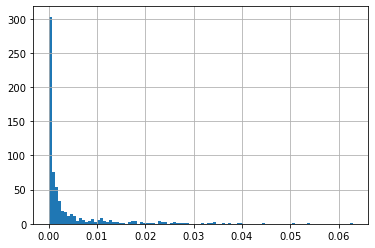

In [10]:

edge_df['normalized_projection_density_source_average'].hist(bins=100)

In [11]:
edge_df['log weight'].mean()

-7.421580372144544

In [115]:
rois = ['ACA','CP','ILM','ATN']
circuit_df = pandas.DataFrame(numpy.zeros((4,4)),index=rois,columns=rois)
circuit_df[rois[0]][rois[0]]
circuit_df.index.name = "target"
circuit_df.columns.name = "source"

In [116]:
values = []
for c in itertools.combinations(rois,2):
    w = edge_df.loc[(edge_df.source==c[0]) & (edge_df.target==c[1])]['log weight'].values
    values.append(w)
    print(f"{c[0]} to {c[1]}: {w}")
    circuit_df[c[0]][c[1]] = w
    w = edge_df.loc[(edge_df.source==c[1]) & (edge_df.target==c[0])]['log weight'].values
    values.append(w)
    print(f"{c[1]} to {c[0]}: {w}")
    circuit_df[c[1]][c[0]] = w
circuit_df

ACA to CP: [-5.11691012]
CP to ACA: [-6.21282758]
ACA to ILM: [-5.41013799]
ILM to ACA: [-6.92816145]
ACA to ATN: [-4.93251404]
ATN to ACA: [-5.25197043]
CP to ILM: [-6.77525829]
ILM to CP: [-5.26832131]
CP to ATN: [-8.51913326]
ATN to CP: [-6.20574402]
ILM to ATN: [-8.47822112]
ATN to ILM: [-7.35887895]


source,ACA,CP,ILM,ATN
target,,,,
ACA,0.000000,-6.212828,-6.928161,-5.251970
CP,-5.116910,0.000000,-5.268321,-6.205744
ILM,-5.410138,-6.775258,0.000000,-7.358879
ATN,-4.932514,-8.519133,-8.478221,0.000000


In [126]:
circuit_edges = circuit_df.to_numpy()
circuit_edges = circuit_edges[circuit_edges != 0]
circuit_edges = circuit_edges.flatten()

array([-6.21282758, -6.92816145, -5.25197043, -5.11691012, -5.26832131,
       -6.20574402, -5.41013799, -6.77525829, -7.35887895, -4.93251404,
       -8.51913326, -8.47822112])

In [21]:
ttest_ind(edge_df['log weight'].values,values)

Ttest_indResult(statistic=array([-3.26441414]), pvalue=array([0.00109894]))

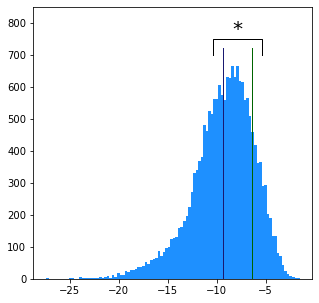

In [169]:
f=plt.figure(figsize=(5,5))

x1 = edge_df['log weight'].mean()
x2 = circuit_edges.mean()

edge_df['log weight'].hist(bins=100,color='dodgerblue')
plt.axvline(x=x1,ymax=0.85,color='midnightblue',lw=1)

#plt.hist(circuit_edges,density=True,bins=4)
plt.axvline(x=x2,ymax=0.85,color='darkgreen',lw=1)


y1=700
y2=750
x1 = x1 - 1
x2 = x2 + 1
plt.plot([x1,x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='k')
plt.text((x1+x2)*.5, y2, "*", ha='center', va='bottom', color="black",fontsize=20)
plt.ylim(0,850)

ax = f.gca()
ax.grid(False)

plt.savefig("figures/network-visualizations/edge-comparisons.svg")
plt.savefig("figures/network-visualizations/edge-comparisons.png")

In [12]:
G = nx.DiGraph()
#below define nodes from source
nodes=node_input
idx=list(range(0,len(nodes)))

#G.add_nodes_from(idx)
G.add_nodes_from(nodes)

top_percentile = 1
bottom_percentile = 75

zero=numpy.percentile(edge_df['log weight'], bottom_percentile) 
large=numpy.percentile(edge_df['log weight'], 100-top_percentile)-zero

#adds edges to G from the average normalized projection densities for each source -> target relationship
for (x,y) in itertools.product(node_input,node_input):
    query_df = edge_df.copy()
    query_df = query_df.loc[(query_df.source == x) & (query_df.target ==y)]
    if query_df.shape[0] == 0:
        continue
    elif query_df['log weight'].iloc[0] < zero:
        continue
    weight = query_df['log weight'].iloc[0]-zero
    G.add_edge(x,y,weight=weight)

In [13]:
zero

-5.702548198989994

In [14]:
zero=0
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > large]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if (d['weight'] <= large) & (d['weight'] > zero)]
ezero = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] <= zero]
enonzero = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > zero]
weights=[d['weight'] for (u, v, d) in G.edges(data=True) if d['weight'] > zero]

print('large is over '+str(large))
print('zero is below '+str(zero))
print(len(elarge))
print(len(esmall))
print(len(ezero))

large is over 2.3977386697788488
zero is below 0
7
156
0


In [15]:
max_weight=numpy.max(weights)

edge_colors = [w/max_weight for w in weights]
edge_alphas = [w/max_weight for w in weights]

len(weights)

163

In [16]:
#pos = nx.kamada_kawai_layout(G)
pos = nx.spring_layout(G)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  app.launch_new_instance()


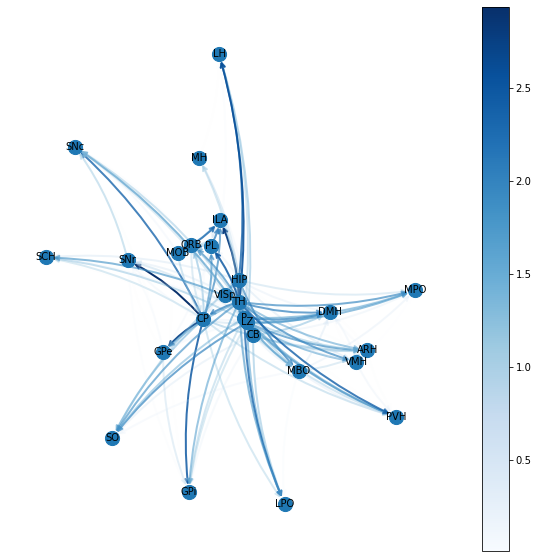

In [17]:
plt.figure(figsize=(10,10))
# nodes
nx.draw_networkx_nodes(G, pos, node_size=200)
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif');

edges=nx.draw_networkx_edges(G, pos, node_size=200, edgelist=enonzero,
                             arrowstyle='->', arrowsize=10, width=2,
                               connectionstyle='arc3, rad=0.1',
                             edge_color=weights, edge_cmap=plt.cm.Blues)

for i in range(len(edges)):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(weights)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.savefig("figures/allnodes-spring_layout_edges.svg")
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


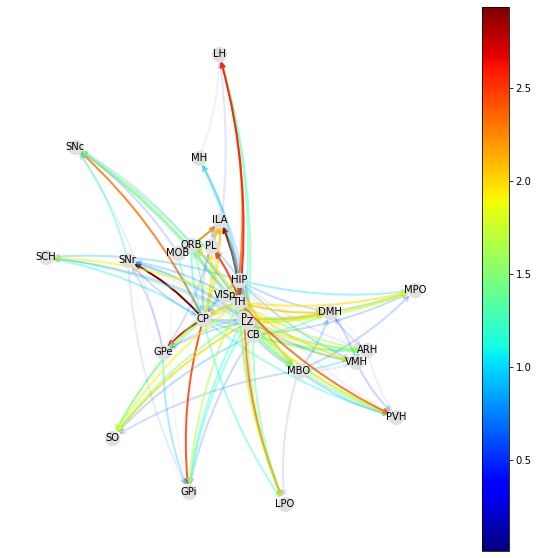

In [18]:
plt.figure(figsize=(10,10))

# nodes
nx.draw_networkx_nodes(G, pos, node_size=200,node_color='#E0E0E0')
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

edges=nx.draw_networkx_edges(G, pos, node_size=200, edgelist=enonzero,
                             arrowstyle='->', arrowsize=10, width=2,
                               connectionstyle='arc3, rad=0.1',
                             edge_color=weights, edge_cmap=plt.cm.jet)

for i in range(len(edges)):
    edges[i].set_alpha(edge_alphas[i])
    
pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.jet)
pc.set_array(weights)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
#plt.savefig('figures/all_1.svg')
plt.show()

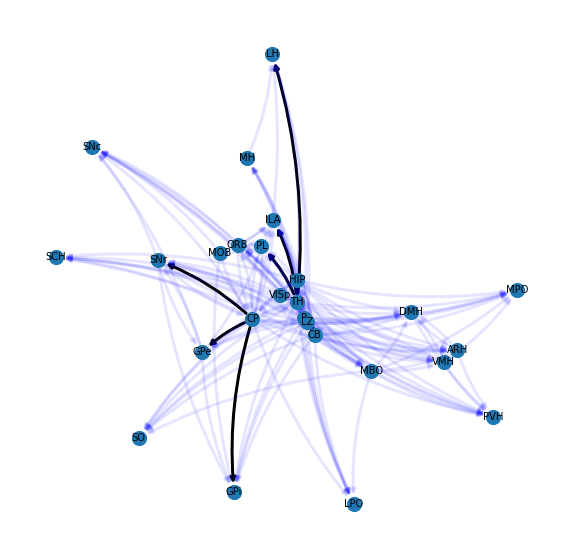

In [19]:
plt.figure(figsize=(10,10))
# nodes
nx.draw_networkx_nodes(G, pos, node_size=200)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge,
                       width=3, connectionstyle='arc3, rad=0.1')
nx.draw_networkx_edges(G, pos, edgelist=esmall,
                       width=3, alpha=0.1, edge_color='b',
                      connectionstyle='arc3, rad=0.1')

nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.axis('off')
#plt.savefig('figures/all_2.svg')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


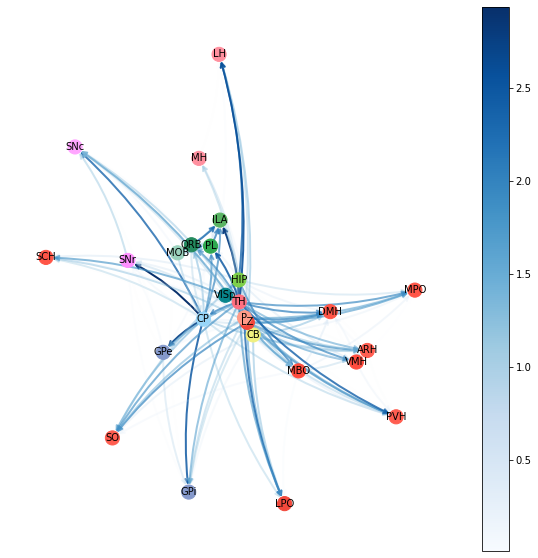

In [20]:
plt.figure(figsize=(10,10))

allen_colors = regions_df.rgb_triplet.values
# nodes
nx.draw_networkx_nodes(G, pos, node_size=200,node_color=[numpy.array(cl)/255 for cl in allen_colors])

# edges
edges=nx.draw_networkx_edges(G, pos, node_size=200, edgelist=enonzero,
                             arrowstyle='->', arrowsize=10, width=2,
                               connectionstyle='arc3, rad=0.1',
                             edge_color=weights, edge_cmap=plt.cm.Blues)

for i in range(len(edges)):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(weights)
plt.colorbar(pc)

nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.axis('off')
plt.savefig('figures/allen_coloring.svg')
plt.show()

In [21]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(numpy.linspace(minval, maxval, n)))
    return new_cmap

In [22]:
node_cen=nx.betweenness_centrality(G, k=None, normalized=True, weight='weight')
cen_scores=[]
for node in node_input:
    cen_scores.append(node_cen[node])

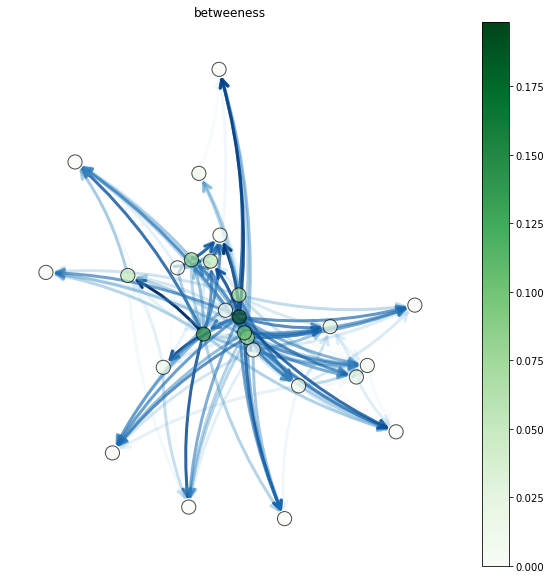

In [23]:
# color the nodes according to their partition
cmap = plt.cm.get_cmap('Greens')
#norm = colors.Normalize(vmin=min(btw_scores),vmax=max(btw_scores))
# edges
plt.figure(figsize=(10,10))
nodes = nx.draw_networkx_nodes(G, pos, node_size=200,
                       cmap=cmap, alpha=0.7,node_color=cen_scores)


edge_cmap=plt.cm.Blues

edge_cmap=truncate_colormap(edge_cmap, 0.4, 1)
edges=nx.draw_networkx_edges(G, pos, node_size=200, edgelist=enonzero,
                             arrowstyle='->', arrowsize=20, width=3,
                               connectionstyle='arc3, rad=0.1',
                             edge_color=weights, edge_cmap=edge_cmap)
for i in range(len(edges)):
    edges[i].set_alpha(edge_alphas[i])
pc = mpl.collections.PatchCollection(edges, cmap=edge_cmap)
pc.set_array(weights)
#plt.colorbar(pc, orientation="horizontal", fraction=0.05)
#nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min(cen_scores), vmax=max(cen_scores)))
plt.colorbar(sm)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
plt.axis('off')
plt.title('betweeness')
plt.savefig('figures/betweenness.svg')
plt.show()

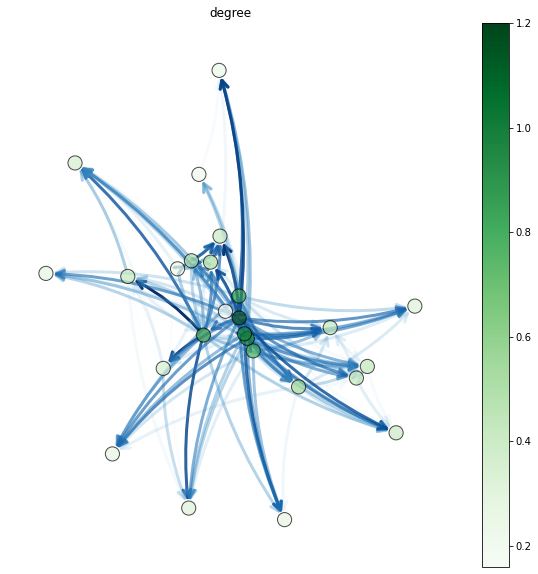

In [24]:
node_cen = nx.degree_centrality(G)
cen_scores=[]
for node in node_input:
    cen_scores.append(node_cen[node])
    
# color the nodes according to their partition
cmap = plt.cm.get_cmap('Greens')
#norm = colors.Normalize(vmin=min(btw_scores),vmax=max(btw_scores))
# edges
plt.figure(figsize=(10,10))
nodes = nx.draw_networkx_nodes(G, pos, node_size=200,
                       cmap=cmap, alpha=0.7,node_color=cen_scores)


edge_cmap=plt.cm.Blues

edge_cmap=truncate_colormap(edge_cmap, 0.4, 1)
edges=nx.draw_networkx_edges(G, pos, node_size=200, edgelist=enonzero,
                             arrowstyle='->', arrowsize=20, width=3,
                               connectionstyle='arc3, rad=0.1',
                             edge_color=weights, edge_cmap=edge_cmap)
for i in range(len(edges)):
    edges[i].set_alpha(edge_alphas[i])
pc = mpl.collections.PatchCollection(edges, cmap=edge_cmap)
pc.set_array(weights)
#plt.colorbar(pc, orientation="horizontal", fraction=0.05)
#nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min(cen_scores), vmax=max(cen_scores)))
plt.colorbar(sm)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
plt.axis('off')
plt.title('degree')
plt.savefig('figures/degree.svg')
plt.show()

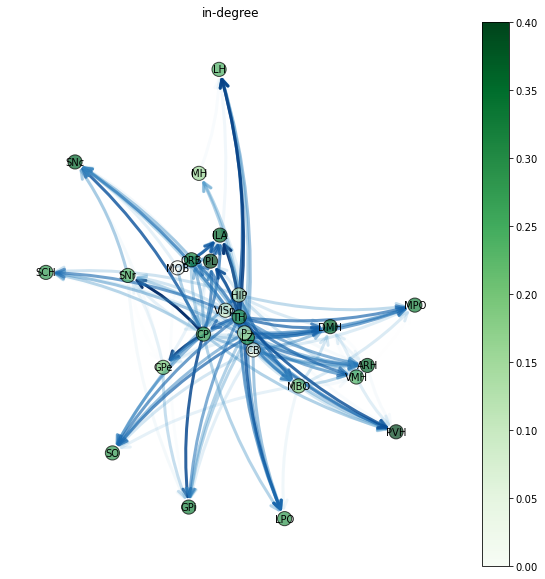

In [25]:
node_cen = nx.in_degree_centrality(G)
cen_scores=[]
for node in node_input:
    cen_scores.append(node_cen[node])
    
# color the nodes according to their partition
cmap = plt.cm.get_cmap('Greens')
#norm = colors.Normalize(vmin=min(btw_scores),vmax=max(btw_scores))
# edges
plt.figure(figsize=(10,10))
nodes = nx.draw_networkx_nodes(G, pos, node_size=200,
                       cmap=cmap, alpha=0.7,node_color=cen_scores)


edge_cmap=plt.cm.Blues

edge_cmap=truncate_colormap(edge_cmap, 0.4, 1)
edges=nx.draw_networkx_edges(G, pos, node_size=200, edgelist=enonzero,
                             arrowstyle='->', arrowsize=20, width=3,
                               connectionstyle='arc3, rad=0.1',
                             edge_color=weights, edge_cmap=edge_cmap)
for i in range(len(edges)):
    edges[i].set_alpha(edge_alphas[i])
pc = mpl.collections.PatchCollection(edges, cmap=edge_cmap)
pc.set_array(weights)
#plt.colorbar(pc, orientation="horizontal", fraction=0.05)
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min(cen_scores), vmax=max(cen_scores)))
plt.colorbar(sm)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
plt.axis('off')
plt.title('in-degree')
#plt.savefig('figures/all_3.svg')
plt.show()

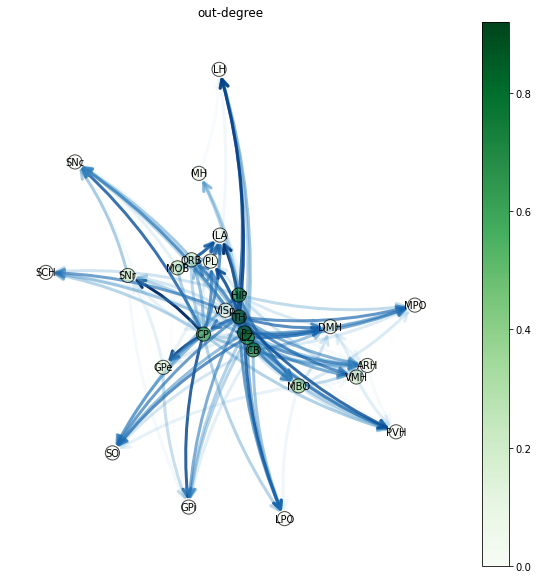

In [26]:
node_cen = nx.out_degree_centrality(G)
cen_scores=[]
for node in node_input:
    cen_scores.append(node_cen[node])
    
# color the nodes according to their partition
cmap = plt.cm.get_cmap('Greens')
#norm = colors.Normalize(vmin=min(btw_scores),vmax=max(btw_scores))
# edges
plt.figure(figsize=(10,10))
nodes = nx.draw_networkx_nodes(G, pos, node_size=200,
                       cmap=cmap, alpha=0.7,node_color=cen_scores)


edge_cmap=plt.cm.Blues

edge_cmap=truncate_colormap(edge_cmap, 0.4, 1)
edges=nx.draw_networkx_edges(G, pos, node_size=200, edgelist=enonzero,
                             arrowstyle='->', arrowsize=20, width=3,
                               connectionstyle='arc3, rad=0.1',
                             edge_color=weights, edge_cmap=edge_cmap)
for i in range(len(edges)):
    edges[i].set_alpha(edge_alphas[i])
pc = mpl.collections.PatchCollection(edges, cmap=edge_cmap)
pc.set_array(weights)
#plt.colorbar(pc, orientation="horizontal", fraction=0.05)
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min(cen_scores), vmax=max(cen_scores)))
plt.colorbar(sm)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
plt.axis('off')
plt.title('out-degree')
#plt.savefig('figures/all_3.svg')
plt.show()

In [27]:
louvain = Louvain()
labels = louvain.fit_transform(nx.adjacency_matrix(G))
print(max(labels)+1)

3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


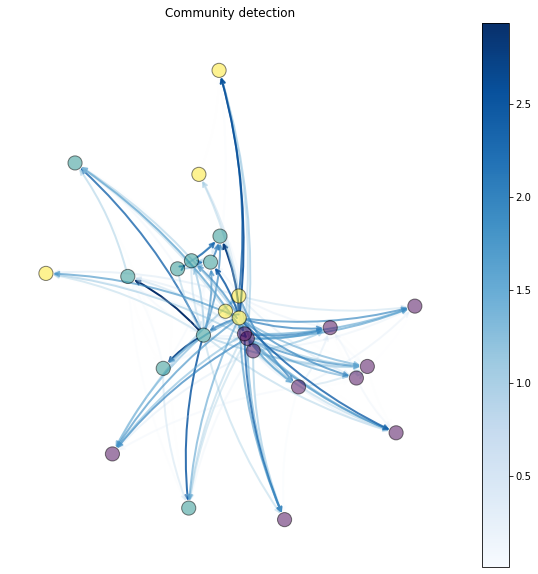

In [28]:
plt.figure(figsize=(10,10))

# nodes
cmap = cm.get_cmap('viridis', max(labels) + 1)
nx.draw_networkx_nodes(G, pos,  node_size=200,
                       cmap=cmap, alpha=0.5,node_color=labels)
#nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

edges=nx.draw_networkx_edges(G, pos, node_size=200, edgelist=enonzero,
                             arrowstyle='->', arrowsize=10, width=2,
                               connectionstyle='arc3, rad=0.1',
                             edge_color=weights, edge_cmap=plt.cm.Blues)

for i in range(len(edges)):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(weights)
plt.colorbar(pc)

plt.title('Community detection')
ax = plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_axis_off()
plt.savefig("figures/louvain.svg")
plt.show()

In [29]:
for k in pos.keys():
    G.nodes[k]['pos']=pos[k]

In [30]:
print(len(enonzero))
print(len(esmall))
print(len(elarge))

163
156
7


In [109]:
aca_cluster = numpy.array(G.nodes())[labels==0]

In [31]:
edge_x = []
edge_y = []
for edge in elarge:
    #if (edge[0] not in aca_cluster) or (edge[1] not in aca_cluster):
    #    continue
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    if (numpy.abs(x0) > 0.4) or (numpy.abs(x1)>0.4) or (numpy.abs(y0)>0.4) or (numpy.abs(y1)>0.4):
        continue
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace1 = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.2, color='#888'),
    hoverinfo='none',
    mode='lines')

edge_x = []
edge_y = []
for edge in esmall:
    #if (edge[0] not in aca_cluster) or (edge[1] not in aca_cluster):
    #    continue
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    if (numpy.abs(x0) > 0.4) or (numpy.abs(x1)>0.4) or (numpy.abs(y0)>0.4) or (numpy.abs(y1)>0.4):
        continue
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace2 = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.05, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        line_width=0.1,
        line_color='black'))


In [32]:
louvain = Louvain(resolution=1)
labels = louvain.fit_transform(nx.adjacency_matrix(G))
cluster_probs = louvain.membership_.todense()

node_cen = nx.betweenness_centrality(G, k=None, normalized=True, weight='weight')
#node_cen = nx.degree_centrality(G)

cen_scores=[]
for node in node_input:
    cen_scores.append(node_cen[node])

In [33]:
#node_trace.marker.color = labels
node_text = [f'{labels[i]+1}: {regions_df.name.values[i]}:</br></br> {cluster_probs[i]}' for i in range(len(cen_scores))]
node_size = (numpy.array(cen_scores)*30/max(cen_scores))+10

cmap="viridis"
cmap=plt.get_cmap(cmap)
colors = cmap(numpy.linspace(0, 1, max(labels)+1))
colors_hex=[mpl.colors.rgb2hex(l) for l in colors]

#colors = [numpy.array(cl)/255 for cl in allen_colors]
#colors_hex=[mpl.colors.rgb2hex(l) for l in colors]

In [34]:
colors_hex

['#440154', '#21918c', '#fde725']

In [181]:
colors_hex[2]="#eb4c34"

In [160]:
rois = ['ACA','ATN','ILM','LAT','MED','MTN','VENT','CP','AI','AHN','SSp','AUDp','MOp']
rois = ['ACA','ATN','ILM','CP']
rois=[]

cen = "Betweenness"

fig = go.Figure(data=[edge_trace1,edge_trace2],
             layout=go.Layout(
                title=f'{cen} Centrality',
                titlefont_size=16,
                showlegend=True,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

for l in range(max(labels)+1):
        #if (l!=0):
        #    continue
        trace_node_x = numpy.array(node_x)[labels==l]
        trace_node_y = numpy.array(node_y)[labels==l]
        trace_text = [node_text[i] for i in range(len(node_x)) if labels[i]==l]
        trace_size = [node_size[i] for i in range(len(node_x)) if labels[i]==l]
        #trace_color = [colors_hex[i] for i in range(len(node_x)) if labels[i]==l]
        
        trace_color = colors_hex[l]
        fig.add_trace(go.Scatter(
            y=trace_node_y,
            x=trace_node_x,
            mode='markers',
            marker_color=trace_color,
            marker_size=trace_size,
            marker_opacity=0.5,
            text=trace_text,
            hoverinfo="text",
            marker_line_color='black',
            marker_line_width=0.1
        ))
        

for i,roi in enumerate(regions):
    roi_idx = node_input.index(roi)
    coord_x = node_x[roi_idx]
    coord_y = node_y[roi_idx]
    fig.add_annotation(x=coord_x, y=coord_y,
                        text=roi,
                        showarrow=False)


plotly.io.write_html(fig, file=f'figures/{cen}-louvain.html')
plotly.io.write_image(fig, file=f'figures/{cen}-louvain.png')
plotly.io.write_image(fig, file=f'figures/{cen}-louvain.svg')

fig.show()

In [38]:
edge_df

,source,target,normalized_projection_density_source_average,log weight
0,ARH,CB,0.000015,-11.080143
1,ARH,CP,0.000015,-11.104207
2,ARH,DMH,0.003601,-5.626433
3,ARH,GPe,0.000014,-11.170178
4,ARH,GPi,0.000098,-9.227046
...,...,...,...,...
645,VMH,SNc,0.000280,-8.180380
646,VMH,SNr,0.000040,-10.126206
647,VMH,SO,0.003234,-5.733998
648,VMH,TH,0.000325,-8.031059


In [49]:
edge_df.loc[(edge_df.source=="ARH") & (edge_df.target=="CP")] 

,source,target,normalized_projection_density_source_average,log weight
1,ARH,CP,0.000015,-11.104207


In [82]:
connectivity_m = numpy.zeros((len(regions),len(regions)))

for i,r1 in enumerate(regions):
    for j,r2 in enumerate(regions):
        if i==j:
            weight=None
        else:
            weight = edge_df.loc[(edge_df.source==r1) & (edge_df.target==r2)]['log weight']
        connectivity_m[i][j]=weight
        
con_zero_m = connectivity_m - numpy.nanmin(connectivity_m)
con_scale_m = con_zero_m / numpy.nanmax(con_zero_m)

In [161]:
edge_df.loc[(edge_df.source=="ARH") & (edge_df.target=="CB")] 

,source,target,normalized_projection_density_source_average,log weight
0,ARH,CB,0.000015,-11.080143


In [162]:
edge_df.loc[(edge_df.source=="CB") & (edge_df.target=="ARH")] 

,source,target,normalized_projection_density_source_average,log weight
25,CB,ARH,0.012263,-4.401207


In [83]:
import seaborn as sns

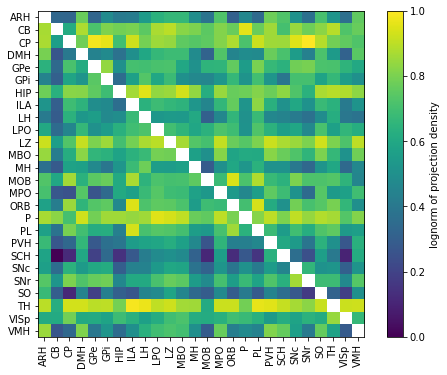

In [101]:
f,ax = plt.subplots(figsize=(8,6))
heatmap = ax.imshow(con_scale_m)
bar = plt.colorbar(heatmap)
bar.set_label("lognorm of projection density")
plt.xticks(list(range(len(regions))),regions,rotation='vertical');
plt.yticks(list(range(len(regions))),regions);

In [115]:
labels

array([0, 0, 1, 0, 1, 1, 2, 1, 2, 0, 0, 0, 2, 1, 0, 1, 0, 1, 0, 2, 1, 1,
       0, 2, 2, 0], dtype=int64)

In [116]:
idx_order = []
for v in range(0,max(labels)+1):
    for i,l in enumerate(labels):
        if l==v:
            idx_order.append(i)

In [111]:
con_scale_m.shape

(26, 26)

In [121]:
regions[idx_order]

array(['ARH', 'CB', 'DMH', 'LPO', 'LZ', 'MBO', 'MPO', 'P', 'PVH', 'SO',
       'VMH', 'CP', 'GPe', 'GPi', 'ILA', 'MOB', 'ORB', 'PL', 'SNc', 'SNr',
       'HIP', 'LH', 'MH', 'SCH', 'TH', 'VISp'], dtype=object)

In [123]:
import matplotlib.patches as patches

In [152]:
idx = numpy.empty_like(idx_order)
idx[idx_order] = numpy.arange(len(idx_order))
idx

array([ 0,  1, 11,  2, 12, 13, 20, 14, 21,  3,  4,  5, 22, 15,  6, 16,  7,
       17,  8, 23, 18, 19,  9, 24, 25, 10])

In [156]:
cluster_scale_m = con_scale_m[:,idx_order]
cluster_scale_m = cluster_scale_m[idx_order,:]

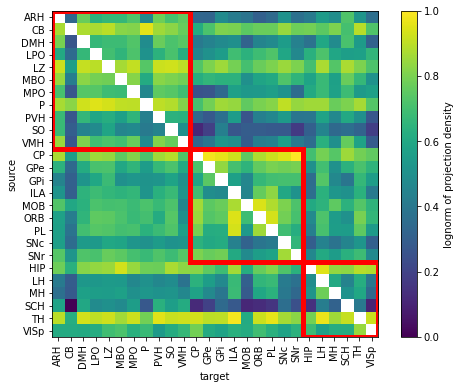

In [163]:
f,ax = plt.subplots(figsize=(8,6))
heatmap = ax.imshow(cluster_scale_m)
bar = plt.colorbar(heatmap)
bar.set_label("lognorm of projection density")
plt.xticks(list(range(len(regions))),regions[idx_order],rotation='vertical');
plt.yticks(list(range(len(regions))),regions[idx_order]);
plt.xlabel("target")
plt.ylabel("source")

startpoint = -0.5
for v in range(0,max(labels)+1):
    num = sum(labels==v)
    clust = patches.Rectangle((startpoint,startpoint),num,num, 
                              linewidth=5,edgecolor='r',facecolor='none')
    startpoint = startpoint + num
    ax.add_patch(clust)
plt.savefig("figures/connectivitymatrix.clustered.svg")
plt.savefig("figures/connectivitymatrix.clustered.png")

In [33]:
regions_df

,acronym,name,id,rgb_triplet
0,AAA,Anterior amygdalar area,23,"[128, 192, 226]"
1,ACA,Anterior cingulate area,31,"[64, 166, 102]"
2,ACB,Nucleus accumbens,56,"[128, 205, 248]"
3,ADP,Anterodorsal preoptic nucleus,72,"[255, 85, 71]"
4,AHN,Anterior hypothalamic nucleus,88,"[255, 76, 62]"
...,...,...,...,...
131,VISpl,Posterolateral visual area,425,"[8, 133, 140]"
132,VISpm,posteromedial visual area,533,"[8, 133, 140]"
133,VPL,Ventral posterolateral nucleus of the thalamus,718,"[255, 128, 132]"
134,VTA,Ventral tegmental area,749,"[255, 144, 255]"
